#  ENRON EMAILS: DOCUMENT CLASSIFICATION

Once the Exploratory phase is over, it is time to leverage every insight gathered in model building decisions. Moreover, we have gained some knowledge about the corpus and most important tokens, so we can judge what is going on with our models.

In this notebook, a binary classification logistic regression model will be trained. In order to do that, it is necessary to transform our corpus into a document-term matrix, so every document will be a labelled observation and the features will be some metric relative to tokens. This process is called *featurization*. The simpliest, yet effective technique is BOW (Bag Of Words) that treats each document a set of tokens, with no relative order or semantic relationship, so it is based on token frequency. 

Previously, to compute TF-IDF, there are some *feature enginnering* tasks that must be performed:
* Preprocessing: Normalization process to enable analytics task.
* Tokenization: Split each document in an array of tokens
* Remove stopwords: Stop words are tokens that, in general, yield a low predictive power, like prepositions, pronoums, and so on. They can be filtered from our array of tokens.

The metric that supports BOW is called TF (Token-Frequency). Given a vocabulary (set of tokens) computes the frequency of token j in document i. A variation of it is called TF-IDF (IDF stands for Inverted Document Frequency) and it penalizes very frequent terms in the document, recall that this is a hint that was discussed during EDA phase.

In [1]:
#!pip install --user --upgrade pixiedust

In [2]:
import pixiedust
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql.types import  *
from pyspark.sql.functions import *
from pyspark.sql import *
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, QuantileDiscretizer 
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression

Pixiedust database opened successfully


## 1. Load and Clean Data

In [3]:
# The code was removed by DSX for sharing.

/gpfs/fs01/user/s842-d3bc14de717513-80bcbeb605c1/notebook/work


In [4]:
# The code was removed by DSX for sharing.

adult.txt	  enron_textfile.txt  mtcars.csv
censusIncome.csv  incomeCensus.txt    spark-warehouse


In [5]:
!head -1 ./enron_textfile.txt

1|North America's integrated electricity market requires cooperation on environmental policies Commission for Environmental Cooperation releases working paper on North America's electricity market Montreal, 27 November 2001 -- The North American Commission for Environmental Cooperation (CEC) is releasing a working paper highlighting the trend towards increasing trade, competition and cross-border investment in electricity between Canada, Mexico and the United States. It is hoped that the working paper, Environmental Challenges and Opportunities in the Evolving North American Electricity Market, will stimulate public discussion around a CEC symposium of the same title about the need to coordinate environmental policies trinationally as a North America-wide electricity market develops. The CEC symposium will take place in San Diego on 29-30 November, and will bring together leading experts from industry, academia, NGOs and the governments of Canada, Mexico and the United States to consid

In order to properly analiyze our corpus, it is necessary to perfrom some preprocessing tasks, this can be time consuming, but it may boost our analytic capability. In this example, we will use an UDF to carry out some basic tasks:
* Eliminate non-alphanumeric characters
* Cast to lowercase
* Trim blanks


In [3]:
UDF_docCleaner= udf(lambda doc: " ".join(re.sub('[^0-9a-zA-Z]+', ' ', doc).
                                             lower().
                                             split()
                                        ), StringType() 
                   )

In [4]:
schema = StructType().\
    add(StructField("id", IntegerType(), True)).\
    add(StructField("email", StringType(), True)).\
    add(StructField("label", DoubleType(), True))
corpus = spark.read.\
    option("sep", "|").\
    option("header", "false").\
    schema(schema).\
    csv("enron_textfile.txt").\
    withColumn('doc', UDF_docCleaner('email'))
    
corpus.persist()
print("First 5 records: ")
corpus.limit(5).toPandas()

First 5 records: 


,id,email,label,doc
0,1,North America's integrated electricity market ...,0,north america s integrated electricity market ...
1,2,"FYI -----Original Message----- From: \t""Ginny ...",1,fyi original message from ginny feliciano gfel...
2,3,"14:13:53 Synchronizing Mailbox 'Kean, Steven J...",0,14 13 53 synchronizing mailbox kean steven j 1...
3,4,^ ----- Forwarded by Steven J Kean/NA/Enron on...,1,forwarded by steven j kean na enron on 03 02 2...
4,5,----- Forwarded by Steven J Kean/NA/Enron on 0...,0,forwarded by steven j kean na enron on 09 26 2...


In [5]:
rank_df = pixiedust.sampleData("https://raw.githubusercontent.com/manualrg/DSLAB_TextAnalytics/master/01_enron_analytics.csv")
print("Top 5 most frequent tokens: ")
rank_df.limit(5).toPandas()

Downloaded 2771817 bytes
Creating pySpark DataFrame for 'https://raw.githubusercontent.com/manualrg/DSLAB_TextAnalytics/master/01_enron_analytics.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://raw.githubusercontent.com/manualrg/DSLAB_TextAnalytics/master/01_enron_analytics.csv'
Top 5 most frequent tokens: 


,token,ndocs,frequency,e,ne,eprop,freq_bins,ndocs_bins,logfreq_bins,rank,...,N0,P1,P0,x,WOEValue,token_length,WOEAbs,flg_singleLabel,WOERanks,lengthRanks
0,enron,512,4977,95,417,0.019088,3,2,3,1,...,716,0.683453,0.582402,1.173507,0.159997,5,0.159997,0,4,3
1,ect,361,4131,52,309,0.012588,3,2,3,2,...,716,0.374101,0.431564,0.866848,-0.142891,3,0.142891,0,3,2
2,com,332,3625,80,252,0.022069,3,2,3,3,...,716,0.575540,0.351955,1.635263,0.491804,3,0.491804,0,4,2
3,hou,329,2051,46,283,0.022428,3,2,3,4,...,716,0.330935,0.395251,0.837278,-0.177599,3,0.177599,0,3,2
4,e,268,1318,66,202,0.050076,3,2,3,5,...,716,0.474820,0.282123,1.683026,0.520593,1,0.520593,0,4,1


In [8]:
display(rank_df.limit(5))

token,ndocs,frequency,e,ne,eprop,freq_bins,ndocs_bins,logfreq_bins,rank,N1,N0,P1,P0,x,WOEValue,token_length,WOEAbs,flg_singleLabel,WOERanks,lengthRanks
enron,512,4977,95.0,417.0,0.0190878038979,3,2,3,1,139,716,0.68345323741,0.582402234637,1.17350723738,0.159996903632,5.0,0.159996903632,0,4.0,3.0
ect,361,4131,52.0,309.0,0.0125877511498,3,2,3,2,139,716,0.374100719424,0.43156424581,0.866848268958,-0.142891324486,3.0,0.142891324486,0,3.0,2.0
com,332,3625,80.0,252.0,0.0220689655172,3,2,3,3,139,716,0.575539568345,0.351955307263,1.635263218,0.491803780992,3.0,0.491803780992,0,4.0,2.0
hou,329,2051,46.0,283.0,0.0224280838615,3,2,3,4,139,716,0.330935251799,0.395251396648,0.837277880876,-0.177599267324,3.0,0.177599267324,0,3.0,2.0
e,268,1318,66.0,202.0,0.0500758725341,3,2,3,5,139,716,0.474820143885,0.282122905028,1.68302585654,0.520593278455,1.0,0.520593278455,0,4.0,1.0


In [9]:
stats = corpus.agg(sum("label").alias("N1"), count("*").alias("N")).toPandas()
stats['N0'] = stats['N']-stats['N1']
stats['baseline_accuracy'] = stats['N0']/stats['N']
stats['apriori'] = 1.0-stats['baseline_accuracy']
stats 


,N1,N,N0,baseline_accuracy,apriori
0,139,855,716,0.837427,0.162573


## 2. Build a Custom Vocabulary Using an Inverted Index Ranking and WOE Metrics

As discussed before, we can build our document-term matrix considering only a subset of tokens, called vocabulary. Let's leverage our WOE analysis, that tells us which tokens yield the lowest predictive power by building a custom set of stopwords that will be removed from our set of tokens: 


* Filter low predictive power tokens: WOERanks 3 and 4
* Exclue tokens belonging to WOERanks=0, because they only appear in label=0 class and may cause overfitting.

In [11]:
#del list
cust_stopu = rank_df.where( col('WOERanks').isin([0,3,4]) ).rdd.map(lambda row: row[0]).collect()
cust_stop = map(lambda token: str(token), cust_stopu)

Default set of stopwords

In [12]:
def_stop = set(StopWordsRemover().getStopWords())

In [13]:
#Join custom and default set of stopwords
stop = list(def_stop.union(cust_stop))
print('Number of tokens in our custom stopwords list: ', len(stop))
print('Five first tokens in our custom stopwrods list:')
for token in stop[:5]:
    print(token)

('Number of tokens in our custom stopwords list: ', 12410)
Five first tokens in our custom stopwrods list:
mdbe
541136
moskowitz
dteenergy
tknox


## 3. Feature Engineering: Bag Of Words (BOW) and TF-IDF Featurization

The output of this step is a ml Pipeline that yiels our document-term matrix in a DataFrame. In this step, we will leverage our knowledge gathered during EDA, setting the minimum token length to 2, adding a custom set of stopwords to remove, and taking into account only the 500 most frequent terms to build the vocabulary.

In [52]:
#Feature Engineering
regexTokenizer = RegexTokenizer().setInputCol("doc").setOutputCol("tokens").\
    setPattern("\\s+").\
    setMinTokenLength(2)
remover = StopWordsRemover().setInputCol("tokens").setOutputCol("tokens_rm").\
    setCaseSensitive(False).\
    setStopWords(stop)
TF = CountVectorizer().setInputCol("tokens_rm").setOutputCol("rawFeatures").\
    setMinTF(10).\
    setVocabSize(500)
idf = IDF().setInputCol("rawFeatures").setOutputCol("features")

stages = [regexTokenizer, remover, TF, idf]
feat_eng_pl = Pipeline().setStages(stages).fit(corpus)
docTerm_df = feat_eng_pl.transform(corpus)
corpus.unpersist()
docTerm_df.persist()
print('Display document-term matrix as a DataFrame: ')
docTerm_df.select('id', 'label', 'features', 'email').limit(10).toPandas()

Display document-term matrix as a DataFrame: 


,id,label,features,email
0,1,0,"(0.0, 0.0, 51.257190919, 0.0, 0.0, 0.0, 0.0, 0...",North America's integrated electricity market ...
1,2,1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","FYI -----Original Message----- From: \t""Ginny ..."
2,3,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","14:13:53 Synchronizing Mailbox 'Kean, Steven J..."
3,4,1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",^ ----- Forwarded by Steven J Kean/NA/Enron on...
4,5,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",----- Forwarded by Steven J Kean/NA/Enron on 0...
5,6,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","George ""Herbert Hoover"" Bush. ""Robert Kean"" <r..."
6,7,1,"(0.0, 59.3239670147, 146.449116911, 108.503284...","See last story attached. Congratulations, it ..."
7,8,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",We plan to send this out Friday. Cynthia will...
8,9,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",APX's presentation about purchasing transmissi...
9,10,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Jim and Margaret: Attached you will find the l...


In [15]:
display(docTerm_df.select('id', 'label', 'features').limit(10))

id,label,features
1,0.0,"(500,[2,8,309],[51.257190919,95.7962522736,124.380477924])"
2,1.0,"(500,[],[])"
3,0.0,"(500,[75],[79.1512132246])"
4,1.0,"(500,[],[])"
5,0.0,"(500,[],[])"
6,0.0,"(500,[],[])"
7,1.0,"(500,[1,2,3,4,9,10,11,14,15,20,25,34,39,45,48,65,70,73,75,83,84,102,109,110,129,134,136,198,261,281],[59.3239670147,146.449116911,108.503284806,83.7464203736,47.028684385,212.404424004,77.4357785797,54.6605495857,62.4826829521,63.7706411833,77.1424869556,101.765845575,49.6051090691,49.6051090691,97.7138168104,64.3917121803,56.5365808747,64.3917121803,84.8048713121,53.6597601502,53.6597601502,121.182463912,49.6051090691,139.515376391,79.3681745106,101.765845575,59.0257361652,186.570716887,118.05147233,73.4975551372])"
8,0.0,"(500,[],[])"
9,0.0,"(500,[69],[169.713471302])"
10,0.0,"(500,[],[])"


In order to build a model, the dataset will be split in train and test at a 0.7/0.3 proportion. As the split is not stratified by label proportion, we will check that label's mean has not changed significantly.

In [17]:
split_weights = [0.7,0.3]
splits = docTerm_df.randomSplit(split_weights, 123)
train = splits[0]
test = splits[1]
print('Train dataframe response analyisis: ')
train.select('label').describe().show()
print('Test dataframe response analyisis: ')
test.select('label').describe().show()

Train dataframe response analyisis: 
+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|               598|
|   mean|0.1588628762541806|
| stddev|0.3658541937006186|
|    min|               0.0|
|    max|               1.0|
+-------+------------------+

Test dataframe response analyisis: 
+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|                257|
|   mean|0.17120622568093385|
| stddev|0.37742407178277504|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [18]:
#Functional Trick: map several operations to a  list of DataFrames and use reduce to contatenate them all
splits_stats = map(lambda df: df[0].select('label').describe().withColumn('sample', lit(df[1]) ), zip(splits, ['train','test']))
label_stats = reduce(lambda dfa, dfb: dfa.union(dfb), splits_stats)
print('Response variable analysis: ')
label_stats.toPandas()

Response variable analysis: 


,summary,label,sample
0,count,598,train
1,mean,0.1588628762541806,train
2,stddev,0.3658541937006186,train
3,min,0.0,train
4,max,1.0,train
5,count,257,test
6,mean,0.17120622568093385,test
7,stddev,0.37742407178277504,test
8,min,0.0,test
9,max,1.0,test


In [19]:
display(label_stats)

summary,label,sample
count,598,train
mean,0.1588628762541806,train
stddev,0.3658541937006186,train
min,0.0,train
max,1.0,train
count,257,test
mean,0.17120622568093385,test
stddev,0.37742407178277504,test
min,0.0,test
max,1.0,test


## 3. Model Building: Logistic Regression

As a initial model, a logistic regression in its simpliest form will be fitted. In Spark ml library, ElasticNet Logistic Regression is implemented, it is a regularization algorithm (shrinks some coefficients to zero) that adds to the optimization function two penalties (L1 or Lasso and L2 or Ridge).

Given **g** as sigmoid function, **x<sup>(i)<sup>** as feature vector and *y<sup>(i)<sup>*  (scalar) as label, the optimization problem is the following:
   
 $$ \text{minimize: } -\frac{1}{m}\sum_{i=1}^m y^{(i)}log(g(wx^{(i)})) + (1-y^{(i)}) log(1-g(wx^{(i)})) + \lambda R$$
$$ R = (1-\alpha)\sum_{j=1}^n \theta^2_{j} + \alpha \sum_{j=1}^n |\theta_{j}|$$

where alpha is the ElasticNet parameter and balances the regularization trade-off between Ridge and Lasso and lambda is the regularization parameter and controls model complexity (the higher its value the simpler model) and overfitting/underfitting. Recall that Lasso can shrink coefficients to exactly zero, while Ridge cannot.

In [20]:
UDF_vecToProb= udf(lambda v:float(v[1]),DoubleType())

In [21]:
lr = LogisticRegression().setFeaturesCol("features").setLabelCol("label").setProbabilityCol("prob_vec").\
    setElasticNetParam(0.0).\
    setRegParam(0.0).\
    setStandardization(True).\
    fit(train)

predictions = map(lambda df : lr.transform(df).withColumn("probability", UDF_vecToProb(col("prob_vec"))), splits)
train_pred = predictions[0]
test_pred = predictions[1]
train_pred.select("id","label", "probability").limit(5).toPandas()

,id,label,probability
0,1,0,6.892111e-39
1,5,0,1.090326e-01
2,6,0,1.090326e-01
3,7,1,1.000000e+00
4,8,0,1.090326e-01


In [ ]:
print("Display 5 first predictions in Train DataFrame:")
display(train_pred.select("id","label", "probability").limit(5))

id,label,probability
1,0.0,6.89211092338e-39
5,0.0,0.109032631244
6,0.0,0.109032631244
7,1.0,1.0
8,0.0,0.109032631244



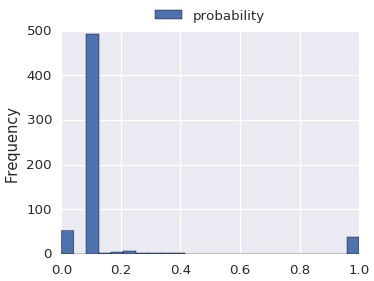

In [ ]:
display(train_pred)


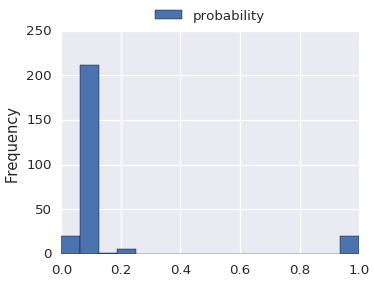

In [24]:
display(test_pred)

## 4. Model Assessment: AUROC and Accuracy

Model assessment wil be carried out by examining AUROC and Accuracy. The first one is not dependent on classification threshold, just on the predicted probability distribution. The second one, depends on the threshold value (by default set to 0.5) but is easily interpretable.

In [29]:
train_eval = lr.summary
train_auroc = train_eval.areaUnderROC
test_eval = lr.evaluate(test)
test_AUROC = test_eval.areaUnderROC
print('Train evaluator instance: ', type(train_eval))
print('Test evaluator instance: ',type(test_eval))

('Train evaluator instance: ', <class 'pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary'>)
('Test evaluator instance: ', <class 'pyspark.ml.classification.BinaryLogisticRegressionSummary'>)


In [30]:
print("Area Under ROC")
print("Train AUROC: ", train_auroc)
print("Test AUROC: ", test_AUROC)

Area Under ROC
('Train AUROC: ', 0.7426075128178299)
('Test AUROC: ', 0.6424455825864275)


In [31]:
train_roc_df =train_eval.roc
train_roc = train_roc_df.toPandas()
test_roc_df = test_eval.roc
test_roc = test_roc_df.toPandas()


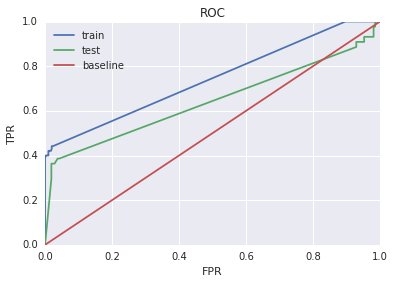

In [32]:
%matplotlib inline
plt.plot(train_roc['FPR'], train_roc['TPR'], label='train')
plt.plot(test_roc['FPR'],test_roc['TPR'], label='test')
plt.plot(train_roc['TPR'], train_roc['TPR'], label='baseline')
# Label the axes
plt.xlabel('FPR')
plt.ylabel('TPR')
#label the figure
plt.title('ROC')
plt.legend(loc=0)
plt.show()

In [51]:
def accuracy(dataset, probabilityCol, labelCol, threshold):
    return  dataset.select(when((col(probabilityCol)>=threshold), 1.0).otherwise(0.0).alias("predClass"), col(labelCol)).\
    withColumn('TP', when((col("predClass") == 1.0) & (col(labelCol) == col("predClass")), 1.0).otherwise(0.0)).\
    withColumn('TN', when((col("predClass") == 0.0) & (col(labelCol) == col("predClass")), 1.0).otherwise(0.0)).\
    withColumn('FP', when((col("predClass") == 1.0) & (col(labelCol) != col("predClass")), 1.0).otherwise(0.0)).\
    withColumn('FN', when((col("predClass") == 0.0) & (col(labelCol) != col("predClass")), 1.0).otherwise(0.0)).\
    agg( sum("TP").alias("TP"), sum("TN").alias("TN"),sum("FP").alias("FP"),sum("FN").alias("FN"), 
        count('*').alias('N'), sum(labelCol).alias('N1')).\
    withColumn('N0', col('N')-col('N1')).\
    withColumn('P1', col('N1')/col('N')).\
    withColumn('P0', col('N0')/col('N')).\
    withColumn('baseline_accuracy', greatest('P1','P0')).\
    withColumn("Accuracy", (col("TP")+col("TN"))/(col("TP")+col("TN")+col("FP")+col("FN")) ).\
    withColumn('threshold', lit(threshold)).drop('P1','P0')


train_acc = accuracy(train_pred, "prediction", "label", 0.5).toPandas()
train_acc['sample'] = 'train'
test_acc = accuracy(test_pred, "prediction", "label", 0.5).toPandas()
test_acc['sample'] = 'test'
acc = pd.concat([train_acc, test_acc])
print('Confusion matrix Report:')
acc

Confusion matrix Report:


,TP,TN,FP,FN,N,N1,N0,baseline_accuracy,Accuracy,threshold,sample
0,37,503,0,58,598,95,503,0.841137,0.903010,0.5,train
0,16,209,4,28,257,44,213,0.828794,0.875486,0.5,test


It can be seen that by fitting a simple model baseline accuracy can be beaten, but AUROC scores are not impressive, given the number of predictors, with a larger dataset, far more complex models can be trained that will beat this performance.

## 5. Feature Analyisis

As our training data is standardized, the scale of the feature is not an issue and we can compare coefficients, remember that in a logistic regression coeffecient **w<sub>(j)<sub>** means:
    
$$ \pi_{i} = P(y_{i}|X_{i}=x_{i}) = \frac{e^{w_{0}+...+w_{j}x_{j}^{(i)}}}{1 + e^{w_{0}+...+w_{j}x_{j}^{(i)}}}$$
    
$$ logit(\pi_{i}=log(\frac{\pi_{i}}{1-\pi_{i}})) = w_{0}+...+w_{j}x_{j}^{(i)}$$

$$ Odds Ratio = e^{logit(\pi_{i})} = \frac{\pi_{i}}{1-\pi_{i}}  = e^{w_{0}}+ ... + e^{w_{j}x_{j}^{(i)}}$$ 

Therefore exp(**w<sub>(j)<sub>**) is the odds ratio corresponding to a one unit change in predictor j

In [29]:
TFModel = feat_eng_pl.stages[2]
type(TFModel)
vocabulary = TFModel.vocabulary
vocab_size = len(vocabulary)
print('Number of tokens in vocabulary: ', vocab_size)
print('First five tokens in vocabulary set: ')
for token in vocabulary[:5]:
    print(token)

('Number of tokens in vocabulary: ', 500)
First five tokens in vocabulary set: 
power
energy
market
gas
would


In [30]:
coefs = lr.coefficients
dic = {"token": vocabulary, "coef": coefs}
coefs_pd = pd.DataFrame(dic).sort_values(by='coef')
print('Top 10 most important tokens to predict label=0:')
coefs_pd[:10]


Top 10 most important tokens to predict label=0:


,coef,token
484,-7.043758,mmbtu
377,-6.881119,pool
46,-6.656443,meeting
270,-6.051312,ed
136,-5.812289,pipeline
72,-5.536688,month
374,-5.372068,paso
290,-5.372068,el
180,-5.346104,calpine
94,-5.252272,costs


In [62]:
rank_df.filter(col('token').isin('mmbtu', 'pool', 'pipeline'))\
    .select('token', 'frequency', 'WOEValue', 'WOERanks',  'eprop').show()

+--------+---------+------------------+--------+-------------------+
|   token|frequency|          WOEValue|WOERanks|              eprop|
+--------+---------+------------------+--------+-------------------+
|pipeline|      128|1.6857262494648468|     5.0|           0.171875|
|    pool|       62|1.1002097330972669|     5.0|0.11290322580645161|
|   mmbtu|       51| 2.006931013955271|     6.0| 0.2549019607843137|
+--------+---------+------------------+--------+-------------------+



In [31]:
print('Top 10 most important tokens to predict label=1:')
coefs_pd[-10:]

Top 10 most important tokens to predict label=1:


,coef,token
97,4.864982,staff
2,5.000493,market
6,5.016006,state
23,5.720001,iso
489,6.422255,calpx
137,7.064481,conference
311,7.483962,bankruptcy
44,8.522938,electric
39,9.611426,contracts
128,10.081511,kaminski


In [61]:
rank_df.filter(col('token').isin('staff', 'market', 'bankruptcy'))\
    .select('token', 'frequency', 'WOEValue', 'WOERanks', 'eprop').show()

+----------+---------+------------------+--------+-------------------+
|     token|frequency|          WOEValue|WOERanks|              eprop|
+----------+---------+------------------+--------+-------------------+
|    market|      878|1.5754904194438462|     5.0|0.08656036446469248|
|     staff|      150|1.6817658482487499|     5.0|               0.16|
|bankruptcy|       72|1.3768419693624627|     5.0| 0.1388888888888889|
+----------+---------+------------------+--------+-------------------+



We have checked some tokens in our token ranking, because we can find energy-related tokens in both lists. As we can see, those tokens yield positive WOEValue (but not very high value) so the model cannot distinguish properly token importance in each label class (or topic). Therefore, a simple model can classificate well enough docuemnts, howerver, it cannot split tokens into topics in order to conduct a more in depth analyisis.

In [32]:
# The code was removed by DSX for sharing.

In [33]:
import ibmos2spark
file = "enron_analytics_clean.csv"
#credentials_1 is a code snippet from  files tab
configurationname1 = "os_" + (credentials_1["project"].replace("object_storage_", "").replace("_", "") ) + "_configs"
#configurationname: 0s_XXXXXX_configs where XXXXX is crendentils("project") substrancting ("object_storage_" and removing  every "_")

bmos = ibmos2spark.bluemix(sc,  credentials_1, configurationname1)
path = bmos.url(credentials_1["container"], file)

In [34]:
print("Saving a PySpark DataFrame as csv file to Bluemix Cloud Object Storage:")
print("Container name: " + credentials_1["container"])
print("File name: " + file)
docTerm_df.select('id','email','doc','label').coalesce(1).write.mode("overwrite").\
    option("delimiter","|").\
    option("header","true").\
    option("treatEmptyValuesAsNulls", "true").\
    csv(path)

Saving a PySpark DataFrame as csv file to Bluemix Cloud Object Storage:
Container name: DSLABTextAnalytics
File name: enron_analytics_clean.csv
